In [1]:
import setGPU

import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import tensorflow as tf
from pylab import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.layers.advanced_activations import PReLU, LeakyReLU
from sklearn.utils import shuffle
import h5py

import getpass
import json

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Anomalous"]



setGPU: Setting GPU to: 3


Using TensorFlow backend.


In [2]:
#Authenticate in order to get permission for eos
os.system("echo %s | kinit" % getpass.getpass())

········


0

In [17]:
#Read history

#group2_autoencoder0 is good: LEAKYRELU both, alpha=0.1, no regualirazers
#group5_autoencoder1 is also very good: PRELU, + l2 regularizer 10e-5
#group0_autoencoder2 not bad looking
#group5_autoencoder2 quite good
name = "group0_autoencoder2"

name = "TestPrelu1"
name = "TestPreluAdadelta_l2e5"
loss = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/%s_loss.npy' % name)
valloss = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/%s_valloss.npy' % name)
testloss = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/%s_testloss.npy' % name)

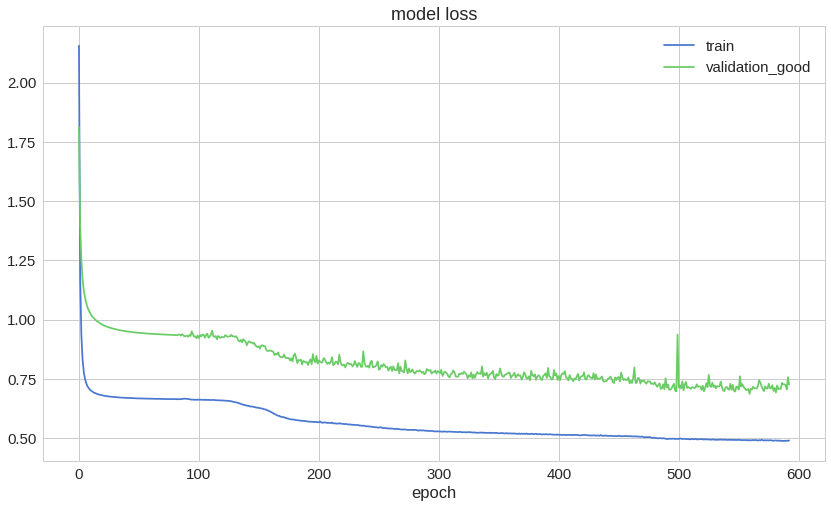

In [18]:
#Visualize history

f = plt.figure()
plt.plot(loss)
# plt.yscale('log')
plt.plot(valloss)
plt.title('model loss')
# plt.plot(testloss)
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation_good', 'test' ], loc='upper right')


In [19]:
#Load files
# history = np.load('/eos/cms/store/user/fsiroky/ae_models/%s.npy' % name)
autoencoder = load_model("/afs/cern.ch/user/f/fsiroky/models_ae/%s.h5" % name)
# autoencoder = load_model("/afs/cern.ch/user/f/fsiroky/public/dec_model.h5")


#CHANGE PATHS TO: /afs/cern.ch/user/f/fsiroky/models_ae/data_eval

X_test = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/X_testfor3pds_model.npy')
y_test = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/y_testfor3pds_model.npy')
last_train_idx = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/last_train_idx.npy')
lumisections = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/lumisections.npy')
lumisections = pd.DataFrame(lumisections)

In [20]:
#Show model architecture
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 2810)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 150)               421650    
_________________________________________________________________
p_re_lu_73 (PReLU)           (None, 150)               150       
_________________________________________________________________
dense_74 (Dense)             (None, 100)               15100     
_________________________________________________________________
p_re_lu_74 (PReLU)           (None, 100)               100       
_________________________________________________________________
dense_75 (Dense)             (None, 50)                5050      
_________________________________________________________________
p_re_lu_75 (PReLU)           (None, 50)                50        
__________

In [21]:
#Make prediction
predictions = autoencoder.predict(X_test)

In [22]:
# #Take mean of 500 worst reconstructed features
# temp = np.partition(-np.power(X_test - predictions, 2), 300)
# result = -temp[:,:300]


# mse = np.mean(result, axis=1)

# error_df = pd.DataFrame({'reconstruction_error': mse,
#                          'true_class': y_test})


In [23]:
def get_error_df(X_test, predictions, y_test, mode='None', n_highest = 100):
    if mode=='allmean':
        mse = np.mean(np.power(X_test - predictions, 2), axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})        
        return error_df
    elif mode=='topn':
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        mse = np.mean(result, axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})
        return error_df
    elif mode=='perobj':
        array_pf_jets =      np.power(X_test[:,0:777] - predictions[:,0:777], 2) # Returns (90294, 777) matrix
#         print(array_pf_jets)
#         print(array_pf_jets.shape)
        mse1 =               np.mean(array_pf_jets, axis=1)
#         print(mse1)
#         print(mse1.shape)
        array_cal_jet_mets = np.power(X_test[:,778:946] - predictions[:,778:946], 2)
        mse2 =               np.mean(array_cal_jet_mets, axis=1)
#         print(mse2)
#         print(mse2.shape)
        array_pho =          np.power(X_test[:,947:1283] - predictions[:,947:1283], 2)
        mse3 =               np.mean(array_pho, axis=1)
        array_muons =        np.power(X_test[:,1284:1788] - predictions[:,1284:1788], 2)
        mse4 =               np.mean(array_muons, axis=1)
        array_pf_jets2=      np.power(X_test[:,1789:1894] - predictions[:,1789:1894], 2)
        mse5 =               np.mean(array_pf_jets2, axis=1)
        array_pf_mets=       np.power(X_test[:,1895:1923] - predictions[:,1895:1923], 2)
        mse6 =               np.mean(array_pf_mets, axis=1)
#         array_nvtx=          np.power(X_test[:,1924] - predictions[:,1924], 2)
#         mse7 =               np.mean(array_nvtx, axis=1)
        array_cal_jet_mets2= np.power(X_test[:,1925:2037] - predictions[:,1925:2037], 2)
        mse8 =               np.mean(array_cal_jet_mets2, axis=1)
        array_sc=            np.power(X_test[:,2038:2122] - predictions[:,2038:2122], 2)
        mse9 =               np.mean(array_sc, axis=1)
        array_cc=            np.power(X_test[:,2123:2165] - predictions[:,2123:2165], 2)
        mse10 =              np.mean(array_cc, axis=1)
        array_pho2=          np.power(X_test[:,2166:2362] - predictions[:,2166:2362], 2)
        mse11 =              np.mean(array_pho2, axis=1)
        array_muons2=        np.power(X_test[:,2363:2489] - predictions[:,2363:2489], 2)
        mse12 =              np.mean(array_muons2, axis=1)
        array_ebs=           np.power(X_test[:,2490:2700] - predictions[:,2490:2700], 2)
        mse13 =              np.mean(array_ebs, axis=1)
        array_hbhef=         np.power(X_test[:,2701:2764] - predictions[:,2701:2764], 2)
        mse14 =              np.mean(array_hbhef, axis=1)
        array_presh=         np.power(X_test[:,2765:2813] - predictions[:,2765:2813], 2)
        mse15 =              np.mean(array_presh, axis=1)
        
        mse = np.maximum.reduce([mse1,mse2,mse3,mse4,mse5,mse6,mse8,mse9,mse10,mse11,mse12,mse13,mse14,mse15])
        error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})
        return error_df
error_df = get_error_df(X_test, predictions, y_test, mode='topn', n_highest = 300)   
# print(error_df)

In [24]:
# luminosity_Test[:,0]

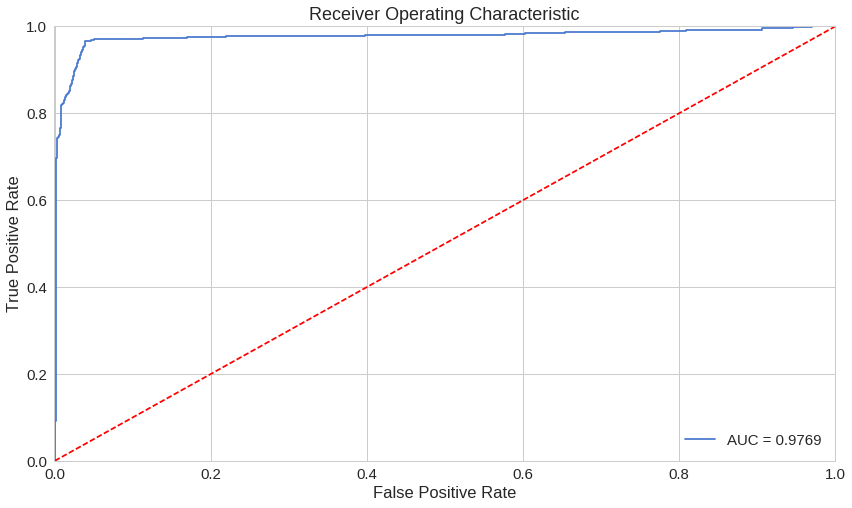

In [25]:
#Make ROC_curve
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_ROC.pdf")

In [26]:
threshold = 20

In [27]:
# y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
# conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# plt.figure(figsize=(12, 12))
# sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show()


Actually good lumis with reconstruction error higher than 20

Actually anomalous lumis with reconstruction error higher than 20


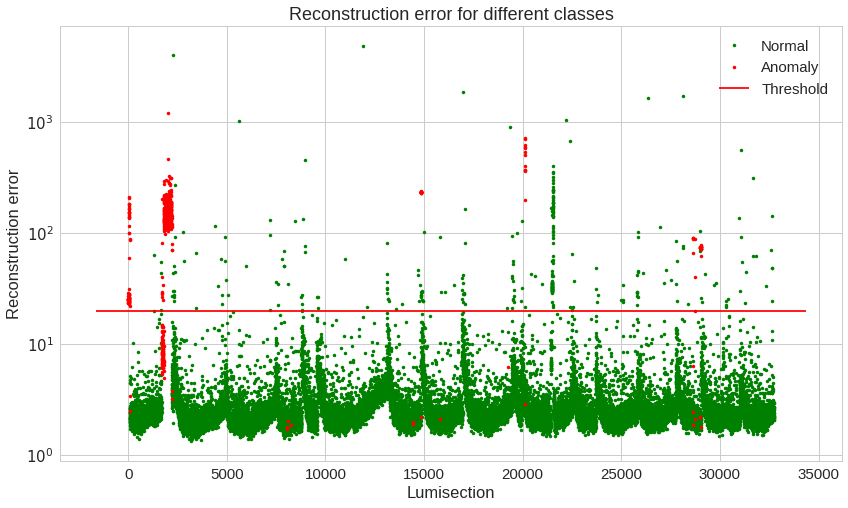

In [28]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
#     print(name)
#     print(group)
    if name == 0:
        print()
        print('Actually good lumis with reconstruction error higher than', threshold)
    elif name ==1:
        print()
        print('Actually anomalous lumis with reconstruction error higher than', threshold)
#     print(group['reconstruction_error'][group['reconstruction_error']<threshold])
    ax.plot(group.index, group.reconstruction_error, color="red" if name == 1 else "green", marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
ax.set_yscale('log')
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Lumisection")
plt.show()

In [29]:
#STUDIES of luminosity dependence on overal error
luminosities_mse  = lumisections.iloc[int(last_train_idx):]
luminosities_mse = luminosities_mse.reset_index(drop=True)
luminosity_Test = lumisections.iloc[int(last_train_idx):].values

In [30]:
#Is one fill: 29047:30470, Runs: 283946 and 283964 



plt.plot(luminosity_Test, mse, marker='o', ms=3.5, linestyle='')
plt.ylabel('Mean rec. error for top 500 worst reconstructed features')
plt.xlabel('Luminosity')
plt.yscale('log')
plt.show()

print(np.average(lumisections))
print(luminosity_Test.shape)

print(mse.shape)

NameError: name 'mse' is not defined

In [31]:
pokokot = luminosity_Test[:,0]

rangeforplotting = "29047:30470"   #FIX THIS, use some string method

luminosityerror_df = pd.DataFrame({'lumrec_error': mse[15000:35470],
                         'luminosity_Test': pokokot[15000:35470],
                                  'true_class': y_test[15000:35470]})

groups = luminosityerror_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
#     print(name)
#     print(group)
    if name == 0:
        print()
#         print('Actually good lumis with reconstruction error higher than', threshold)
    elif name ==1:
        print()
#         print('Actually anomalous lumis with reconstruction error higher than', threshold)
#     print(group['reconstruction_error'][group['reconstruction_error']<threshold])
    ax.plot(group.luminosity_Test, group.lumrec_error, color="red" if name == 1 else "green", marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
#ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
ax.set_yscale('log')
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Luminosity")
plt.show()

NameError: name 'mse' is not defined

In [418]:
pokokot.shape

(32737,)

In [419]:
mse.shape

(32737,)

In [420]:
predictionss = pd.DataFrame(predictions)
var_names_reduced5 = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEnhfEM', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi']
print(len(var_names_reduced5)*7)  #Doesnt contain special features like pathrates or luminosities


2807


In [421]:
def get_type(number):
    if number % 7 == 0:
        return "MEAN"
    if number % 7 == 1:
        return "RMS"
    if number % 7 == 2:
        return "Q1"
    if number % 7 == 3:
        return "Q2"
    if number % 7 == 4:
        return "Q3"
    if number % 7 == 5:
        return "Q4"
    if number % 7 == 6:
        return "Q5"

291




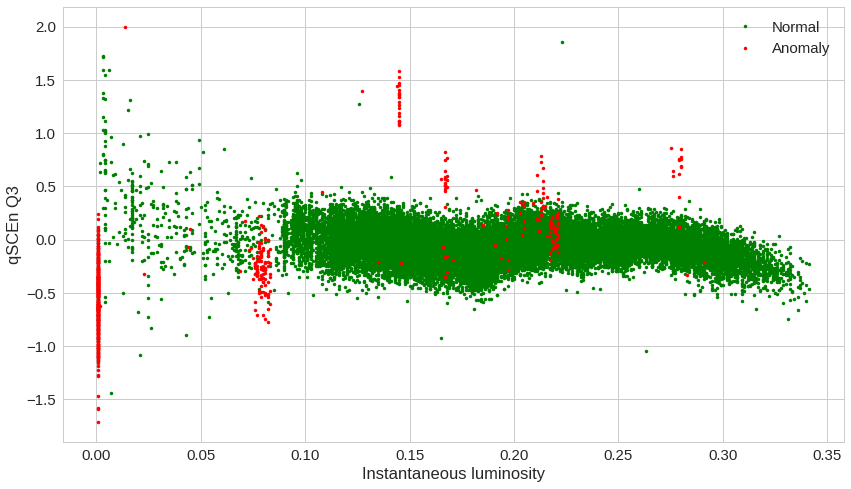

In [452]:
#MEAN, RMS, Q1, Q2, Q3, Q4, Q5, 
vr_name = "qSCEn"
bb = var_names_reduced5.index(vr_name)
print(bb)

nasobek =  bb*7  #Choose index [0 to 401]
X_testt = pd.DataFrame(X_test)   #THIS WAS BREAKING THE LAST PART!
X= 4+ nasobek  #CHoose type [0 to 6]
# xx = X_testt.iloc[29047:30470,X:X+1]  #Can change range here
# yy = predictionss.iloc[29047:30470,X:X+1] #Can change range here
xx = X_testt.iloc[:,X:X+1]
yy = predictionss.iloc[:,X:X+1]


pokokot = luminosity_Test[:,0]

rangeforplotting = "29047:30470"   #FIX THIS, use some string method

difference = xx - yy

varerror_df = pd.DataFrame({'vartest_err': difference.values[:,0],
                            'luminosity_Test': pokokot,
                                  'true_class': y_test})

groups = varerror_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
#     print(name)
#     print(group)
    if name == 0:
        print()
    elif name ==1:
        print()
#     print(group['reconstruction_error'][group['reconstruction_error']<threshold])
    ax.plot(group.luminosity_Test, (group.vartest_err) , color="red" if name == 1 else "green", marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
#ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()


plt.ylabel(vr_name+" "+get_type(X))
plt.ylabel(str(var_names_reduced5[int(nasobek/7)])+" "+get_type(X))
plt.xlabel("Instantaneous luminosity")

plt.show()

# print(np.average(xx-yy))

In [423]:
# xx.values[:,0]

In [426]:
chosen_idx = 30470
runIDS = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/datarunIDs.npy')
runIDS = pd.DataFrame(runIDS)
lumiIDS = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/datalumiIDs.npy')
lumiIDS = pd.DataFrame(lumiIDS)

#29047 beginning of 283946 run and fill
#30159 end of 283946 run... lumiid 1456. However, should end in 1462 according to Run Registry
#    Is the problem in crab jobs failures or my program?  -- now there could be a difference because I have two validation sets
#30470 is the last lumi in run 283964 of one fill

# last_train_idx = 130947   #
print('RunID of chosen lumi:',  int(runIDS.ix[chosen_idx+last_train_idx])) #or 
print('LumiID of chosen lumi:',int(lumiIDS.ix[chosen_idx+last_train_idx]))

#342745   3PDs
# print('RunID of chosen lumi:', int(data[2800].ix[chosen_idx]))
# print('LumiID of chosen lumi:',int(data[2801].ix[chosen_idx]))

RunID of chosen lumi: 283964
LumiID of chosen lumi: 388


chosen_idx is:  30470


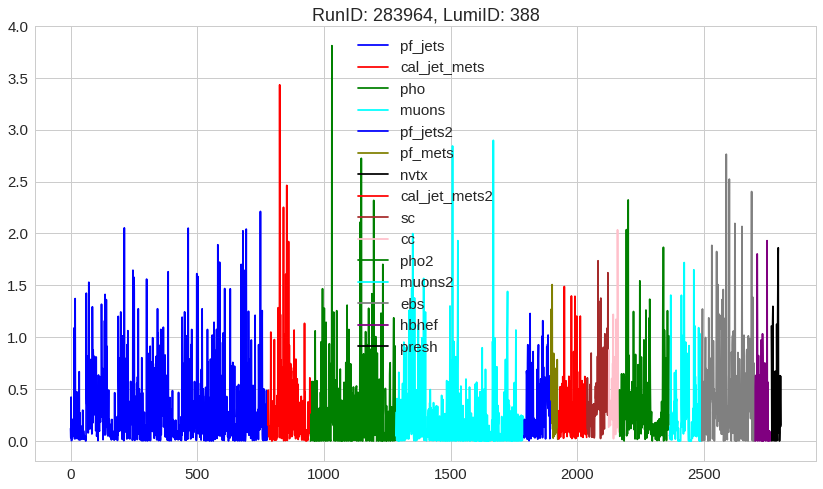

In [427]:
if 'chosen_idx' in globals():
    print('chosen_idx is: ', chosen_idx)
else:
    chosen_idx = 1
    print('temporarily chosen_idx is: ', chosen_idx)
    
    
# testset_idx = chosen_idx - 80781    #because 80780 # might not be like that anymoreis last index of training lumisection ##In case jupyter on eos is fixed
testset_idx = chosen_idx              #342745 last index of training lumisec
# print(X_test[0] - predictions[0])
my_vec = X_test[testset_idx] - predictions[testset_idx]  #ONLZ WORKS WHEN X_TEST AND PREDICTIONS ARE NOT PANDAS FRAME/LOADED STRAIGHT FROM

                
my_vec = np.array(abs(my_vec))
pd_vec = pd.DataFrame(my_vec)

incr_vec = []
for i in range (0,2810):
    incr_vec.append(i)
incr_vec = np.array(incr_vec)

#FIX THE INTERVALS -- needs small update! check with h5maker.py

plt.plot(incr_vec[0:777],     pd_vec[0:777],     color='blue')          #pf_jets
plt.plot(incr_vec[778:946],   pd_vec[778:946],   color='red')           #cal_jet_mets
plt.plot(incr_vec[947:1283],  pd_vec[947:1283],  color='green')         #pho
plt.plot(incr_vec[1284:1788], pd_vec[1284:1788], color='cyan')          #muons
plt.plot(incr_vec[1789:1894], pd_vec[1789:1894], color='blue')          #pf_jets2
plt.plot(incr_vec[1895:1923], pd_vec[1895:1923], color='olive')         #pf_mets
plt.plot(incr_vec[1924:1925], pd_vec[1924:1925], color='black')         #nvtx
plt.plot(incr_vec[1925:2037], pd_vec[1925:2037], color='red')           #cal_jet_mets2
plt.plot(incr_vec[2038:2122], pd_vec[2038:2122], color='brown')         #sc
plt.plot(incr_vec[2123:2165], pd_vec[2123:2165], color='pink')          #cc
plt.plot(incr_vec[2166:2362], pd_vec[2166:2362], color='green')         #pho2
plt.plot(incr_vec[2363:2489], pd_vec[2363:2489], color='cyan')          #muons2
plt.plot(incr_vec[2490:2700], pd_vec[2490:2700], color='gray')          #ebs
plt.plot(incr_vec[2701:2764], pd_vec[2701:2764], color='purple')        #hbhef
plt.plot(incr_vec[2765:2803], pd_vec[2765:2803], color='black')         #presh


plt.legend(['pf_jets', 'cal_jet_mets', 'pho', 'muons', 'pf_jets2', 'pf_mets', 'nvtx', 
           'cal_jet_mets2', 'sc', 'cc', 'pho2', 'muons2', 'ebs', 'hbhef', 'presh'], loc='best')

plt.title('RunID: '+ str(int(runIDS.ix[chosen_idx+last_train_idx]))+', '+ 'LumiID: '+ str(int(lumiIDS.ix[chosen_idx+last_train_idx])))

pd_vec = pd_vec.sort_values([0], ascending=False)

index_store = -1
for i in range (len(incr_vec)):
    if pd_vec[0][i] > 5*pd_vec[0][i+1]:
        index_store = i
        break
# print(index_store)
# pd_vec


# print(index_store)
# print(kokonat.shape)

# var_names_reduced5 = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi']
# test_novej         = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEnhfEM', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi']

# print(len(var_names_reduced5)*7)


# teeeest = [('qPFJetPt', 'O'), ('qPFJetEta', 'O'), ('qPFJetPhi', 'O'), ('qPFJet0Pt', 'O'), ('qPFJet1Pt', 'O'), ('qPFJet2Pt', 'O'), ('qPFJet3Pt', 'O'), ('qPFJet4Pt', 'O'), ('qPFJet5Pt', 'O'), ('qPFJet0Eta', 'O'), ('qPFJet1Eta', 'O'), ('qPFJet2Eta', 'O'), ('qPFJet3Eta', 'O'), ('qPFJet4Eta', 'O'), ('qPFJet5Eta', 'O'), ('qPFJet0Phi', 'O'), ('qPFJet1Phi', 'O'), ('qPFJet2Phi', 'O'), ('qPFJet3Phi', 'O'), ('qPFJet4Phi', 'O'), ('qPFJet5Phi', 'O'), ('qPFJet4CHS0Pt', 'O'), ('qPFJet4CHS1Pt', 'O'), ('qPFJet4CHS2Pt', 'O'), ('qPFJet4CHS3Pt', 'O'), ('qPFJet4CHS4Pt', 'O'), ('qPFJet4CHS5Pt', 'O'), ('qPFJet4CHS0Eta', 'O'), ('qPFJet4CHS1Eta', 'O'), ('qPFJet4CHS2Eta', 'O'), ('qPFJet4CHS3Eta', 'O'), ('qPFJet4CHS4Eta', 'O'), ('qPFJet4CHS5Eta', 'O'), ('qPFJet4CHS0Phi', 'O'), ('qPFJet4CHS1Phi', 'O'), ('qPFJet4CHS2Phi', 'O'), ('qPFJet4CHS3Phi', 'O'), ('qPFJet4CHS4Phi', 'O'), ('qPFJet4CHS5Phi', 'O'), ('qPFJet8CHS0Pt', 'O'), ('qPFJet8CHS1Pt', 'O'), ('qPFJet8CHS2Pt', 'O'), ('qPFJet8CHS3Pt', 'O'), ('qPFJet8CHS4Pt', 'O'), ('qPFJet8CHS5Pt', 'O'), ('qPFJet8CHS0Eta', 'O'), ('qPFJet8CHS1Eta', 'O'), ('qPFJet8CHS2Eta', 'O'), ('qPFJet8CHS3Eta', 'O'), ('qPFJet8CHS4Eta', 'O'), ('qPFJet8CHS5Eta', 'O'), ('qPFJet8CHS0Phi', 'O'), ('qPFJet8CHS1Phi', 'O'), ('qPFJet8CHS2Phi', 'O'), ('qPFJet8CHS3Phi', 'O'), ('qPFJet8CHS4Phi', 'O'), ('qPFJet8CHS5Phi', 'O'), ('qPFJetEI0Pt', 'O'), ('qPFJetEI1Pt', 'O'), ('qPFJetEI2Pt', 'O'), ('qPFJetEI3Pt', 'O'), ('qPFJetEI4Pt', 'O'), ('qPFJetEI5Pt', 'O'), ('qPFJetEI0Eta', 'O'), ('qPFJetEI1Eta', 'O'), ('qPFJetEI2Eta', 'O'), ('qPFJetEI3Eta', 'O'), ('qPFJetEI4Eta', 'O'), ('qPFJetEI5Eta', 'O'), ('qPFJetEI0Phi', 'O'), ('qPFJetEI1Phi', 'O'), ('qPFJetEI2Phi', 'O'), ('qPFJetEI3Phi', 'O'), ('qPFJetEI4Phi', 'O'), ('qPFJetEI5Phi', 'O'), ('qPFJet8CHSSD0Pt', 'O'), ('qPFJet8CHSSD1Pt', 'O'), ('qPFJet8CHSSD2Pt', 'O'), ('qPFJet8CHSSD3Pt', 'O'), ('qPFJet8CHSSD4Pt', 'O'), ('qPFJet8CHSSD5Pt', 'O'), ('qPFJet8CHSSD0Eta', 'O'), ('qPFJet8CHSSD1Eta', 'O'), ('qPFJet8CHSSD2Eta', 'O'), ('qPFJet8CHSSD3Eta', 'O'), ('qPFJet8CHSSD4Eta', 'O'), ('qPFJet8CHSSD5Eta', 'O'), ('qPFJet8CHSSD0Phi', 'O'), ('qPFJet8CHSSD1Phi', 'O'), ('qPFJet8CHSSD2Phi', 'O'), ('qPFJet8CHSSD3Phi', 'O'), ('qPFJet8CHSSD4Phi', 'O'), ('qPFJet8CHSSD5Phi', 'O'), ('qPFJetTopCHS0Pt', 'O'), ('qPFJetTopCHS1Pt', 'O'), ('qPFJetTopCHS2Pt', 'O'), ('qPFJetTopCHS3Pt', 'O'), ('qPFJetTopCHS4Pt', 'O'), ('qPFJetTopCHS5Pt', 'O'), ('qPFJetTopCHS0Eta', 'O'), ('qPFJetTopCHS1Eta', 'O'), ('qPFJetTopCHS2Eta', 'O'), ('qPFJetTopCHS3Eta', 'O'), ('qPFJetTopCHS4Eta', 'O'), ('qPFJetTopCHS5Eta', 'O'), ('qPFJetTopCHS0Phi', 'O'), ('qPFJetTopCHS1Phi', 'O'), ('qPFJetTopCHS2Phi', 'O'), ('qPFJetTopCHS3Phi', 'O'), ('qPFJetTopCHS4Phi', 'O'), ('qPFJetTopCHS5Phi', 'O'), ('qCalJet0Pt', 'O'), ('qCalJet1Pt', 'O'), ('qCalJet2Pt', 'O'), ('qCalJet3Pt', 'O'), ('qCalJet4Pt', 'O'), ('qCalJet5Pt', 'O'), ('qCalJet0Eta', 'O'), ('qCalJet1Eta', 'O'), ('qCalJet2Eta', 'O'), ('qCalJet3Eta', 'O'), ('qCalJet4Eta', 'O'), ('qCalJet5Eta', 'O'), ('qCalJet0Phi', 'O'), ('qCalJet1Phi', 'O'), ('qCalJet2Phi', 'O'), ('qCalJet3Phi', 'O'), ('qCalJet4Phi', 'O'), ('qCalJet5Phi', 'O'), ('qCalJet0En', 'O'), ('qCalJet1En', 'O'), ('qCalJet2En', 'O'), ('qCalJet3En', 'O'), ('qCalJet4En', 'O'), ('qCalJet5En', 'O'), ('qPho0Pt', 'O'), ('qPho1Pt', 'O'), ('qPho2Pt', 'O'), ('qPho3Pt', 'O'), ('qPho4Pt', 'O'), ('qPho5Pt', 'O'), ('qPho0Eta', 'O'), ('qPho1Eta', 'O'), ('qPho2Eta', 'O'), ('qPho3Eta', 'O'), ('qPho4Eta', 'O'), ('qPho5Eta', 'O'), ('qPho0Phi', 'O'), ('qPho1Phi', 'O'), ('qPho2Phi', 'O'), ('qPho3Phi', 'O'), ('qPho4Phi', 'O'), ('qPho5Phi', 'O'), ('qPho0En', 'O'), ('qPho1En', 'O'), ('qPho2En', 'O'), ('qPho3En', 'O'), ('qPho4En', 'O'), ('qPho5En', 'O'), ('qgedPho0Pt', 'O'), ('qgedPho1Pt', 'O'), ('qgedPho2Pt', 'O'), ('qgedPho3Pt', 'O'), ('qgedPho4Pt', 'O'), ('qgedPho5Pt', 'O'), ('qgedPho0Eta', 'O'), ('qgedPho1Eta', 'O'), ('qgedPho2Eta', 'O'), ('qgedPho3Eta', 'O'), ('qgedPho4Eta', 'O'), ('qgedPho5Eta', 'O'), ('qgedPho0Phi', 'O'), ('qgedPho1Phi', 'O'), ('qgedPho2Phi', 'O'), ('qgedPho3Phi', 'O'), ('qgedPho4Phi', 'O'), ('qgedPho5Phi', 'O'), ('qgedPho0En', 'O'), ('qgedPho1En', 'O'), ('qgedPho2En', 'O'), ('qgedPho3En', 'O'), ('qgedPho4En', 'O'), ('qgedPho5En', 'O'), ('qMu0Pt', 'O'), ('qMu1Pt', 'O'), ('qMu2Pt', 'O'), ('qMu3Pt', 'O'), ('qMu4Pt', 'O'), ('qMu5Pt', 'O'), ('qMu0Eta', 'O'), ('qMu1Eta', 'O'), ('qMu2Eta', 'O'), ('qMu3Eta', 'O'), ('qMu4Eta', 'O'), ('qMu5Eta', 'O'), ('qMu0Phi', 'O'), ('qMu1Phi', 'O'), ('qMu2Phi', 'O'), ('qMu3Phi', 'O'), ('qMu4Phi', 'O'), ('qMu5Phi', 'O'), ('qMu0En', 'O'), ('qMu1En', 'O'), ('qMu2En', 'O'), ('qMu3En', 'O'), ('qMu4En', 'O'), ('qMu5En', 'O'), ('qMuCosm0Pt', 'O'), ('qMuCosm1Pt', 'O'), ('qMuCosm2Pt', 'O'), ('qMuCosm3Pt', 'O'), ('qMuCosm4Pt', 'O'), ('qMuCosm5Pt', 'O'), ('qMuCosm0Eta', 'O'), ('qMuCosm1Eta', 'O'), ('qMuCosm2Eta', 'O'), ('qMuCosm3Eta', 'O'), ('qMuCosm4Eta', 'O'), ('qMuCosm5Eta', 'O'), ('qMuCosm0Phi', 'O'), ('qMuCosm1Phi', 'O'), ('qMuCosm2Phi', 'O'), ('qMuCosm3Phi', 'O'), ('qMuCosm4Phi', 'O'), ('qMuCosm5Phi', 'O'), ('qMuCosm0En', 'O'), ('qMuCosm1En', 'O'), ('qMuCosm2En', 'O'), ('qMuCosm3En', 'O'), ('qMuCosm4En', 'O'), ('qMuCosm5En', 'O'), ('qMuCosmLeg0Pt', 'O'), ('qMuCosmLeg1Pt', 'O'), ('qMuCosmLeg2Pt', 'O'), ('qMuCosmLeg3Pt', 'O'), ('qMuCosmLeg4Pt', 'O'), ('qMuCosmLeg5Pt', 'O'), ('qMuCosmLeg0Eta', 'O'), ('qMuCosmLeg1Eta', 'O'), ('qMuCosmLeg2Eta', 'O'), ('qMuCosmLeg3Eta', 'O'), ('qMuCosmLeg4Eta', 'O'), ('qMuCosmLeg5Eta', 'O'), ('qMuCosmLeg0Phi', 'O'), ('qMuCosmLeg1Phi', 'O'), ('qMuCosmLeg2Phi', 'O'), ('qMuCosmLeg3Phi', 'O'), ('qMuCosmLeg4Phi', 'O'), ('qMuCosmLeg5Phi', 'O'), ('qMuCosmLeg0En', 'O'), ('qMuCosmLeg1En', 'O'), ('qMuCosmLeg2En', 'O'), ('qMuCosmLeg3En', 'O'), ('qMuCosmLeg4En', 'O'), ('qMuCosmLeg5En', 'O'), ('qPFJet4CHSPt', 'O'), ('qPFJet4CHSEta', 'O'), ('qPFJet4CHSPhi', 'O'), ('qPFJet8CHSPt', 'O'), ('qPFJet8CHSEta', 'O'), ('qPFJet8CHSPhi', 'O'), ('qPFJetEIPt', 'O'), ('qPFJetEIEta', 'O'), ('qPFJetEIPhi', 'O'), ('qPFJet8CHSSDPt', 'O'), ('qPFJet8CHSSDEta', 'O'), ('qPFJet8CHSSDPhi', 'O'), ('qPFJetTopCHSPt', 'O'), ('qPFJetTopCHSEta', 'O'), ('qPFJetTopCHSPhi', 'O'), ('qPFChMetPt', 'O'), ('qPFChMetPhi', 'O'), ('qPFMetPt', 'O'), ('qPFMetPhi', 'O'), ('qNVtx', 'O'), ('qCalJetPt', 'O'), ('qCalJetEta', 'O'), ('qCalJetPhi', 'O'), ('qCalJetEn', 'O'), ('qCalMETPt', 'O'), ('qCalMETPhi', 'O'), ('qCalMETEn', 'O'), ('qCalMETBEPt', 'O'), ('qCalMETBEPhi', 'O'), ('qCalMETBEEn', 'O'), ('qCalMETBEFOPt', 'O'), ('qCalMETBEFOPhi', 'O'), ('qCalMETBEFOEn', 'O'), ('qCalMETMPt', 'O'), ('qCalMETMPhi', 'O'), ('qCalMETMEn', 'O'), ('qSCEn', 'O'), ('qSCEta', 'O'), ('qSCPhi', 'O'), ('qSCEtaWidth', 'O'), ('qSCPhiWidth', 'O'), ('qSCEnhfEM', 'O'), ('qSCEtahfEM', 'O'), ('qSCPhihfEM', 'O'), ('qSCEn5x5', 'O'), ('qSCEta5x5', 'O'), ('qSCPhi5x5', 'O'), ('qSCEtaWidth5x5', 'O'), ('qSCPhiWidth5x5', 'O'), ('qCCEn', 'O'), ('qCCEta', 'O'), ('qCCPhi', 'O'), ('qCCEn5x5', 'O'), ('qCCEta5x5', 'O'), ('qCCPhi5x5', 'O'), ('qPhoPt', 'O'), ('qPhoEta', 'O'), ('qPhoPhi', 'O'), ('qPhoEn_', 'O'), ('qPhoe1x5_', 'O'), ('qPhoe2x5_', 'O'), ('qPhoe3x3_', 'O'), ('qPhoe5x5_', 'O'), ('qPhomaxenxtal_', 'O'), ('qPhosigmaeta_', 'O'), ('qPhosigmaIeta_', 'O'), ('qPhor1x5_', 'O'), ('qPhor2x5_', 'O'), ('qPhor9_', 'O'), ('qgedPhoPt', 'O'), ('qgedPhoEta', 'O'), ('qgedPhoPhi', 'O'), ('qgedPhoEn_', 'O'), ('qgedPhoe1x5_', 'O'), ('qgedPhoe2x5_', 'O'), ('qgedPhoe3x3_', 'O'), ('qgedPhoe5x5_', 'O'), ('qgedPhomaxenxtal_', 'O'), ('qgedPhosigmaeta_', 'O'), ('qgedPhosigmaIeta_', 'O'), ('qgedPhor1x5_', 'O'), ('qgedPhor2x5_', 'O'), ('qgedPhor9_', 'O'), ('qMuPt', 'O'), ('qMuEta', 'O'), ('qMuPhi', 'O'), ('qMuEn_', 'O'), ('qMuCh_', 'O'), ('qMuChi2_', 'O'), ('qMuCosmPt', 'O'), ('qMuCosmEta', 'O'), ('qMuCosmPhi', 'O'), ('qMuCosmEn_', 'O'), ('qMuCosmCh_', 'O'), ('qMuCosmChi2_', 'O'), ('qMuCosmLegPt', 'O'), ('qMuCosmLegEta', 'O'), ('qMuCosmLegPhi', 'O'), ('qMuCosmLegEn_', 'O'), ('qMuCosmLegCh_', 'O'), ('qMuCosmLegChi2_', 'O'), ('qSigmaIEta', 'O'), ('qSigmaIPhi', 'O'), ('qr9', 'O'), ('qHadOEm', 'O'), ('qdrSumPt', 'O'), ('qdrSumEt', 'O'), ('qeSCOP', 'O'), ('qecEn', 'O'), ('qUNSigmaIEta', 'O'), ('qUNSigmaIPhi', 'O'), ('qUNr9', 'O'), ('qUNHadOEm', 'O'), ('qUNdrSumPt', 'O'), ('qUNdrSumEt', 'O'), ('qUNeSCOP', 'O'), ('qUNecEn', 'O'), ('qEBenergy', 'O'), ('qEBtime', 'O'), ('qEBchi2', 'O'), ('qEBiEta', 'O'), ('qEBiPhi', 'O'), ('qEEenergy', 'O'), ('qEEtime', 'O'), ('qEEchi2', 'O'), ('qEEix', 'O'), ('qEEiy', 'O'), ('qESenergy', 'O'), ('qEStime', 'O'), ('qESix', 'O'), ('qESiy', 'O'), ('qHBHEenergy', 'O'), ('qHBHEtime', 'O'), ('qHBHEauxe', 'O'), ('qHBHEieta', 'O'), ('qHBHEiphi', 'O'), ('qHFenergy', 'O'), ('qHFtime', 'O'), ('qHFieta', 'O'), ('qHFiphi', 'O'), ('qPreShEn', 'O'), ('qPreShEta', 'O'), ('qPreShPhi', 'O'), ('qPreShYEn', 'O'), ('qPreShYEta', 'O'), ('qPreShYPhi', 'O')]
# print(len(teeeest))

#88656  is Actually good lumis with reconstruction error higher than 70, MUONS problem
#99594  is Actually good lumis with reconstruction error higher than 70, PHOTONS problem
#97348  is Actually good lumis with reconstruction error 48, MUONS problem

#89180  is Actually anomalous lumis with reconstruction error higher than 70, LOTS of problems
#89283  is Actually anomalous lumis with reconstruction error higher than 70, LOTS of problems

#83163 is Actually good lumi with reconstruction error lower than 0.3

#89248 is Actually anomalous lumi classified as good with rec. error ~1.5
#89252 is Actually anomalous lumi classified as good with rec. error ~ 25  --
#89254  # -- THIS IS INTERESTING = only big problem in PFJets but because other objects are fine, it doesn't say
        # that it is anomalous -- objects represented by more variables have more decision power
        # SOLUTION? claim lumisection anomalous when already some variables of some object go over some treshold
        # and not just an average.
        # SOLUTION_2 - some sort of weighted average or something cleverer
#89255 similar story, also mostly pf_jet and little bit EBS too